In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio
import os
import glob
import polars as pl
import json
import re
import joblib
import matplotlib.pyplot as plt
from rasterio.sample import sample_gen
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, make_scorer, mean_poisson_deviance, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import PoissonRegressor
from shapely.geometry import Point

In [2]:
parambasedir =  '/mnt/d/readyparams/param_csvs'
baseoutputdir = '/mnt/d/readyparams'
sp = 'Protonotaria_citrea'.lower()

In [3]:
# Paths
if not os.path.exists(baseoutputdir):
    outputdir = os.path.join(baseoutputdir,'ppp_paramsoutput')
    os.makedirs(outputdir, exist_ok=True)
    outputdir = os.path.join(outputdir,sp)
    os.makedirs(outputdir, exist_ok=True)
else:
    outputdir = baseoutputdir    

In [4]:
# === Load Presence Points ===

# Find matching files
csv_files = glob.glob(os.path.join(parambasedir, f"*{sp}*.csv"))

dfs = []
for file_path in csv_files:
    print(f"Reading: {file_path}")

    # Read CSV
    df = pl.read_csv(file_path)
    # Extract lon/lat
    df = df.with_columns([
        pl.col(".geo").map_elements(lambda x: json.loads(x)["coordinates"][0], return_dtype=pl.Float64).alias("longitude"),
        pl.col(".geo").map_elements(lambda x: json.loads(x)["coordinates"][1], return_dtype=pl.Float64).alias("latitude")
    ])
    
    # Drop unnecessary columns
    df = df.drop(["system:index", ".geo"])
    
    
    dfs.append(df)
    
combined_df = pl.concat(dfs, how='diagonal')

combined_df = combined_df.with_columns(
    pl.lit(1).alias("label")  # constant string
)
len(combined_df)

Reading: /mnt/d/readyparams/param_csvs/_projects_gbif_protonotaria_citrea_subset0.csv
Reading: /mnt/d/readyparams/param_csvs/_projects_gbif_protonotaria_citrea_subset1.csv
Reading: /mnt/d/readyparams/param_csvs/_projects_gbif_protonotaria_citrea_subset2.csv
Reading: /mnt/d/readyparams/param_csvs/_projects_gbif_protonotaria_citrea_subset3.csv
Reading: /mnt/d/readyparams/param_csvs/_projects_gbif_protonotaria_citrea_subset4.csv
Reading: /mnt/d/readyparams/param_csvs/_projects_gbif_protonotaria_citrea_subset5.csv
Reading: /mnt/d/readyparams/param_csvs/_projects_gbif_protonotaria_citrea_subset6.csv
Reading: /mnt/d/readyparams/param_csvs/_projects_gbif_protonotaria_citrea_subset7.csv
Reading: /mnt/d/readyparams/param_csvs/_projects_gbif_protonotaria_citrea_subset8.csv
Reading: /mnt/d/readyparams/param_csvs/_projects_gbif_protonotaria_citrea_subset9.csv


825

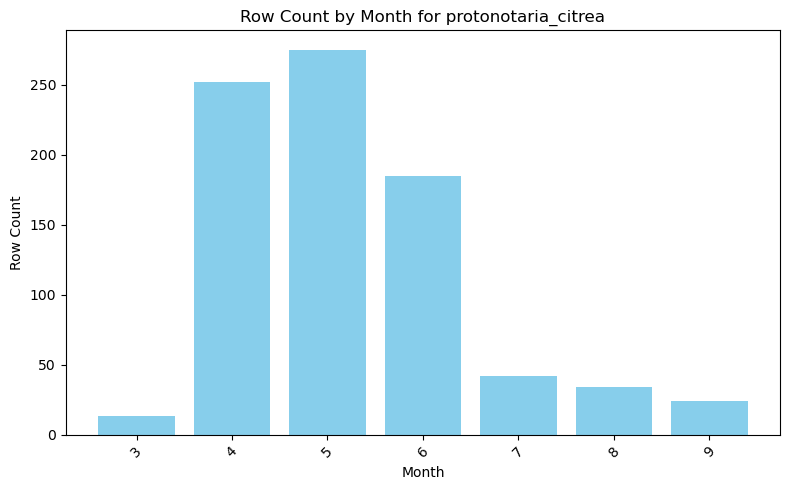

In [5]:
# Ensure 'month' column exists
if "month" not in combined_df.columns:
    combined_df = combined_df.with_columns(
        pl.col("obs_date")
        .str.strptime(pl.Date, format="%Y-%m-%d")  # ✅ use 'format' instead of 'fmt'
        .dt.month()
        .alias("month")
    )

# Count rows by month
month_counts = (
    combined_df
    .group_by("month")
    .len()
    .sort("month")
)


# Convert to pandas for plotting
month_counts_pd = month_counts.to_pandas()

# Plot
plt.figure(figsize=(8, 5))
plt.bar(month_counts_pd["month"], month_counts_pd["len"], color="skyblue")
plt.title(f"Row Count by Month for {sp}")
plt.xlabel("Month")
plt.ylabel("Row Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(outputdir,f"CountByMonth_{sp}.png"))
plt.show()

In [6]:
csv_files = glob.glob(os.path.join(parambasedir, f"*background*.csv"))

bgs = []
for file_path in csv_files:
    print(f"Reading: {file_path}")

    # Read CSV
    bg = pl.read_csv(file_path)
    # Extract lon/lat
    bg = bg.with_columns([
        pl.col(".geo").map_elements(lambda x: json.loads(x)["coordinates"][0], return_dtype=pl.Float64).alias("longitude"),
        pl.col(".geo").map_elements(lambda x: json.loads(x)["coordinates"][1], return_dtype=pl.Float64).alias("latitude")
    ])
    
    # Drop unnecessary columns
    bg = bg.drop(["system:index", ".geo"])
    
    
    bgs.append(bg)
    
combined_bg = pl.concat(bgs, how='diagonal')
combined_bg = combined_bg.with_columns(
    pl.lit(0).alias("label")  # constant string
)
len(combined_bg)

Reading: /mnt/d/readyparams/param_csvs/projects_ee-mkmitchellducks_assets_gbif_background_pts.csv


9932

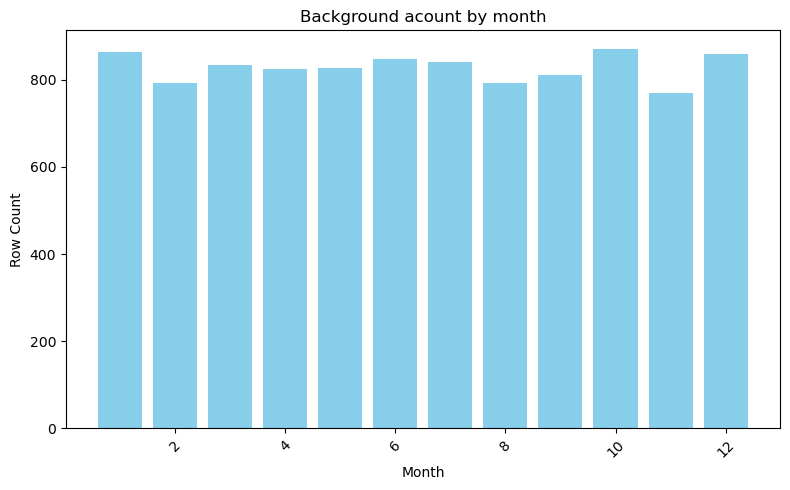

In [7]:
# Count rows by month

combined_bg = combined_bg.with_columns(
    pl.col("obs_date").str.to_datetime(strict=False).dt.month().alias("month")
)

month_counts = (
    combined_bg
    .group_by("month")
    .len()
    .sort("month")  # optional: sort chronologically if month is numeric or formatted
)

# Convert to pandas for plotting
month_counts_pd = month_counts.to_pandas()

# Plot
plt.figure(figsize=(8, 5))
plt.bar(month_counts_pd["month"], month_counts_pd["len"], color="skyblue")
plt.title(f"Background acount by month")
plt.xlabel("Month")
plt.ylabel("Row Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
from sklearn.preprocessing import MinMaxScaler
# === Combine and Train ===
print(combined_df.columns)
print(combined_bg.columns)
data = pd.concat([combined_df.to_pandas(), combined_bg.to_pandas()], ignore_index=True)
print(data.columns)
print(len(data))
#data.to_parquet(f"{spyear}_training_data.parquet", index=False)
X = data.drop(columns=['basisofrecord', 'coordinateuncertaintyinmeters', 'species', 'rand','date', 'day', 'month', 'obs_date', 'observation_date', 'protocol_name', 'scientific_name', 'year', 'longitude', 'latitude', 'label'],errors='ignore')
#predictors = data.drop(columns=['date', 'day', 'month', 'obs_date', 'observation_date', 'protocol_name', 'scientific_name', 'year', 'longitude', 'latitude', 'label'],errors='ignore').columns
y = data['label']
X = X.fillna(0)
scaler = MinMaxScaler(feature_range=(0, 100))
X['forest_edge_100'] = scaler.fit_transform(X[['forest_edge_100']])
X['forest_edge_10000'] = scaler.fit_transform(X[['forest_edge_10000']])
X_scaled = X
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

['date', 'day', 'dw_class_0_pct_10000m', 'dw_class_0_pct_100m', 'dw_class_1_pct_10000m', 'dw_class_1_pct_100m', 'dw_class_2_pct_10000m', 'dw_class_2_pct_100m', 'dw_class_3_pct_10000m', 'dw_class_3_pct_100m', 'dw_class_4_pct_10000m', 'dw_class_4_pct_100m', 'dw_class_5_pct_10000m', 'dw_class_5_pct_100m', 'dw_class_6_pct_10000m', 'dw_class_6_pct_100m', 'dw_class_7_pct_10000m', 'dw_class_7_pct_100m', 'dw_class_8_pct_10000m', 'dw_class_8_pct_100m', 'forest_core_pct_100', 'forest_core_pct_10000', 'forest_edge_100', 'forest_edge_10000', 'month', 'obs_date', 'observation_date', 'protocol_name', 'scientific_name', 'year', 'longitude', 'latitude', 'label']
['dw_class_0_pct_10000m', 'dw_class_0_pct_100m', 'dw_class_1_pct_10000m', 'dw_class_1_pct_100m', 'dw_class_2_pct_10000m', 'dw_class_2_pct_100m', 'dw_class_3_pct_10000m', 'dw_class_3_pct_100m', 'dw_class_4_pct_10000m', 'dw_class_4_pct_100m', 'dw_class_5_pct_10000m', 'dw_class_5_pct_100m', 'dw_class_6_pct_10000m', 'dw_class_6_pct_100m', 'dw_clas

In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score, precision_score, recall_score
import rasterio

# ------------------------
# === Helper: Batched Poisson Prediction ===
# ------------------------
def batched_predict_poisson(model, X, batch_size=100000):
    n = X.shape[0]
    y_intensity = np.full(n, np.nan)
    
    for i in range(0, n, batch_size):
        end = min(i + batch_size, n)
        batch = X[i:end]
        
        if np.isnan(batch).all():
            continue
        
        valid = ~np.isnan(batch).any(axis=1)
        if np.any(valid):
            preds = model.predict(batch[valid])
            y_intensity[i:end][valid] = preds

    y_intensity /= np.nanmax(y_intensity)
    return y_intensity

def batched_scale(X, scaler, batch_size=100000):
    n = X.shape[0]
    X_scaled = np.full_like(X, np.nan, dtype=np.float32)
    
    for i in range(0, n, batch_size):
        end = min(i + batch_size, n)
        batch = X[i:end]
        
        valid = ~np.isnan(batch).any(axis=1)
        if np.any(valid):
            X_scaled[i:end][valid] = scaler.transform(batch[valid])
    
    return X_scaled

# ------------------------
# === 5-Fold Cross-Validation ===
# ------------------------
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metrics = []

for train_idx, test_idx in kf.split(X_scaled, y):
    #X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    #y_train, y_test = y[train_idx], y[test_idx]
    X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Presence = 1, background = small constant
    y_train_poisson = np.where(y_train==1, 1.0, 1e-4)
    
    model = PoissonRegressor(alpha=1e-4, max_iter=10000)
    model.fit(X_train, y_train_poisson)
    
    # Predict
    y_pred_intensity = model.predict(X_test)
    y_pred_prob = y_pred_intensity / y_pred_intensity.max()
    
    # Metrics
    y_pred_bin = (y_pred_prob >= 0.5).astype(int)
    auc = roc_auc_score(y_test, y_pred_prob)
    f1 = f1_score(y_test, y_pred_bin)
    precision = precision_score(y_test, y_pred_bin)
    recall = recall_score(y_test, y_pred_bin)
    
    metrics.append({'auc': auc, 'f1': f1, 'precision': precision, 'recall': recall})

# Average metrics
mean_metrics = {k: np.mean([m[k] for m in metrics]) for k in metrics[0].keys()}
print("5-Fold CV Mean Metrics:", mean_metrics)

# ------------------------
# === Train Final Model on Full Dataset ===
# ------------------------
y_poisson_full = np.where(y==1, 1.0, 1e-4)
final_model = PoissonRegressor(alpha=1e-4, max_iter=10000)
final_model.fit(X_scaled, y_poisson_full)

5-Fold CV Mean Metrics: {'auc': np.float64(0.838613210224849), 'f1': np.float64(0.07300954334406408), 'precision': np.float64(0.6411111111111111), 'recall': np.float64(0.03878787878787878)}


,alpha,0.0001
,fit_intercept,True
,solver,'lbfgs'
,max_iter,10000
,tol,0.0001
,warm_start,False
,verbose,0


In [10]:
def safe_poisson_deviance(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-6, None)  # avoid zero
    return mean_poisson_deviance(y_true, y_pred)

scorer = make_scorer(safe_poisson_deviance, greater_is_better=False)
scores = cross_val_score(model, X, y, scoring=scorer, cv=5)
print("Mean Poisson Deviance:", -scores.mean())


/home/mike/miniforge3/envs/rapids-25.10/lib/python3.13/site-packages/sklearn/_loss/link.py:175: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)


Mean Poisson Deviance: 2.0938694514691836


In [11]:
coef = model.coef_
features = X.columns  # if X is a DataFrame
importance_df = pd.DataFrame({
    'feature': features,
    'coefficient': coef,
    'abs_importance': abs(coef)
}).sort_values('abs_importance', ascending=False)

print(importance_df)

                  feature  coefficient  abs_importance
16  dw_class_8_pct_10000m    -1.347726        1.347726
17    dw_class_8_pct_100m    -0.628876        0.628876
19  forest_core_pct_10000     0.198012        0.198012
2   dw_class_1_pct_10000m    -0.156177        0.156177
15    dw_class_7_pct_100m    -0.106977        0.106977
10  dw_class_5_pct_10000m     0.092594        0.092594
14  dw_class_7_pct_10000m     0.092433        0.092433
4   dw_class_2_pct_10000m     0.085742        0.085742
0   dw_class_0_pct_10000m     0.071542        0.071542
12  dw_class_6_pct_10000m     0.067768        0.067768
9     dw_class_4_pct_100m    -0.063974        0.063974
5     dw_class_2_pct_100m    -0.049432        0.049432
11    dw_class_5_pct_100m    -0.040621        0.040621
13    dw_class_6_pct_100m    -0.040544        0.040544
3     dw_class_1_pct_100m    -0.038000        0.038000
21      forest_edge_10000     0.035188        0.035188
1     dw_class_0_pct_100m    -0.034376        0.034376
8   dw_cla

<Figure size 800x600 with 0 Axes>

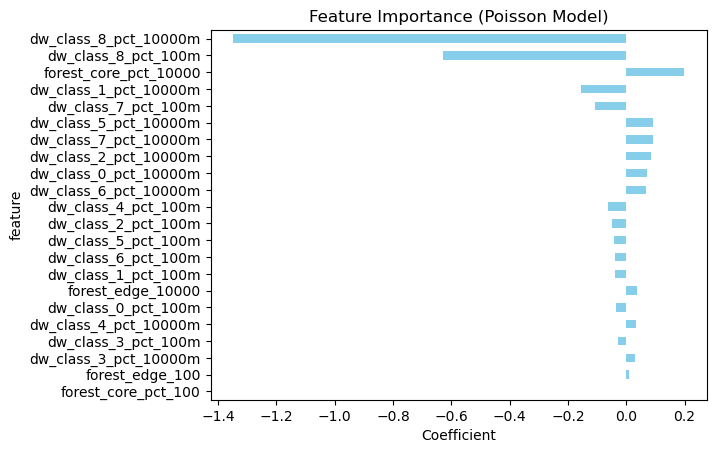

In [12]:
plt.figure(figsize=(8, 6))
importance_df.sort_values('abs_importance', ascending=True).plot.barh(
    x='feature', y='coefficient', color='skyblue', legend=False
)
plt.title('Feature Importance (Poisson Model)')
plt.xlabel('Coefficient')
plt.savefig(os.path.join(outputdir,f"FeatureImportance_{sp}.png"))
plt.show()


Alpha Tuning Results:
alpha=0.000001 | F1=0.3543 | Precision=0.2633 | Recall=0.5418 | AUC=0.8369
alpha=0.000100 | F1=0.3562 | Precision=0.2484 | Recall=0.6291 | AUC=0.8364
alpha=0.001000 | F1=0.3536 | Precision=0.2362 | Recall=0.7030 | AUC=0.8349
alpha=0.010000 | F1=0.3596 | Precision=0.2467 | Recall=0.6630 | AUC=0.8366
alpha=0.100000 | F1=0.3724 | Precision=0.2702 | Recall=0.5988 | AUC=0.8374
alpha=1.000000 | F1=0.3522 | Precision=0.2618 | Recall=0.5382 | AUC=0.8265


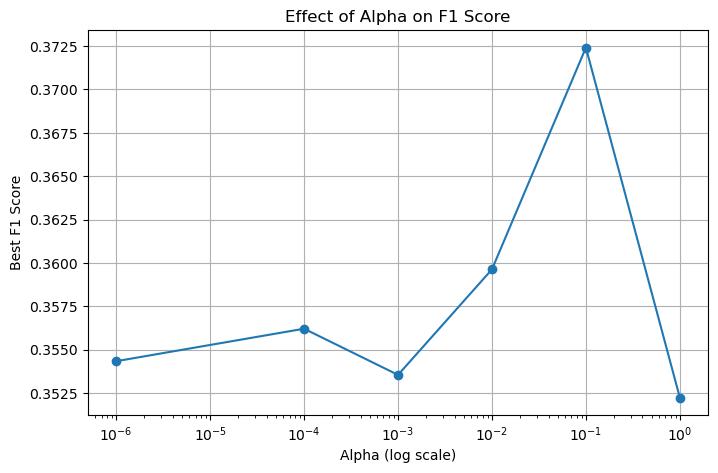

In [13]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler

# -------------------------
# Scale features
# -------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

alpha_values = [1e-6, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]  # ✅ test different alphas
alpha_results = []

for alpha in alpha_values:
    all_y_true = []
    all_y_pred_prob = []

    # -------------------------
    # Cross-validation loop
    # -------------------------
    for train_idx, test_idx in kf.split(X_scaled, y):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Presence = 1, background = small constant
        y_train_poisson = np.where(y_train == 1, 1.0, 1e-4)

        model = PoissonRegressor(alpha=alpha, max_iter=1000)
        model.fit(X_train, y_train_poisson)

        # Predict intensity and normalize to probability
        y_pred_intensity = model.predict(X_test)
        y_pred_prob = y_pred_intensity / y_pred_intensity.max()

        all_y_true.extend(y_test)
        all_y_pred_prob.extend(y_pred_prob)

    # Convert to arrays
    all_y_true = np.array(all_y_true)
    all_y_pred_prob = np.array(all_y_pred_prob)

    # -------------------------
    # Find optimal threshold for F1
    # -------------------------
    precisions, recalls, thresholds = precision_recall_curve(all_y_true, all_y_pred_prob)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)

    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    # Apply best threshold
    y_pred_bin = (all_y_pred_prob >= best_threshold).astype(int)

    # Compute metrics at best threshold
    precision_at_best = precision_score(all_y_true, y_pred_bin)
    recall_at_best = recall_score(all_y_true, y_pred_bin)
    roc_auc = auc(*roc_curve(all_y_true, all_y_pred_prob)[:2])

    alpha_results.append({
        "alpha": alpha,
        "best_threshold": best_threshold,
        "best_f1": best_f1,
        "precision": precision_at_best,
        "recall": recall_at_best,
        "roc_auc": roc_auc
    })

# -------------------------
# Print summary
# -------------------------
print("\nAlpha Tuning Results:")
for res in alpha_results:
    print(f"alpha={res['alpha']:.6f} | F1={res['best_f1']:.4f} | Precision={res['precision']:.4f} | Recall={res['recall']:.4f} | AUC={res['roc_auc']:.4f}")

# -------------------------
# Plot F1 vs Alpha
# -------------------------
plt.figure(figsize=(8, 5))
plt.plot([r["alpha"] for r in alpha_results], [r["best_f1"] for r in alpha_results], marker='o')
plt.xscale('log')
plt.xlabel("Alpha (log scale)")
plt.ylabel("Best F1 Score")
plt.title("Effect of Alpha on F1 Score")
plt.grid(True)
plt.savefig(os.path.join(outputdir,f"Alpha_{sp}.png"))
plt.show()


Best Threshold: 0.0903
Precision: 0.2484
Recall: 0.6291
F1 Score: 0.3562
Confusion Matrix:
[[8362 1570]
 [ 306  519]]


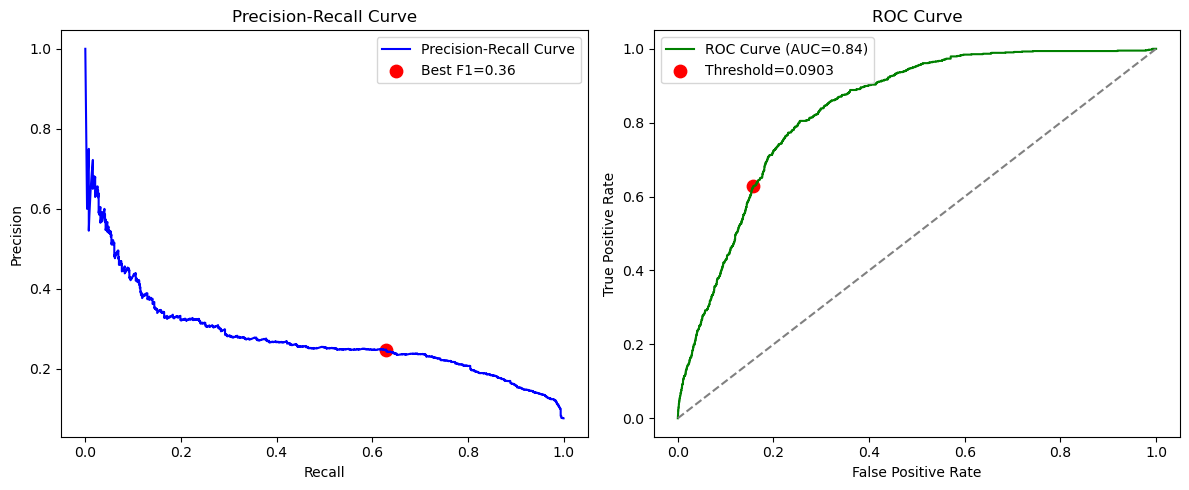

In [14]:
# -------------------------
# Scale features
# -------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_y_true = []
all_y_pred_prob = []

# -------------------------
# Cross-validation loop
# -------------------------
for train_idx, test_idx in kf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Presence = 1, background = small constant
    y_train_poisson = np.where(y_train == 1, 1.0, 1e-4)

    model = PoissonRegressor(alpha=1e-4, max_iter=1000)
    model.fit(X_train, y_train_poisson)

    # Predict intensity and normalize to probability
    y_pred_intensity = model.predict(X_test)
    y_pred_prob = y_pred_intensity / y_pred_intensity.max()

    all_y_true.extend(y_test)
    all_y_pred_prob.extend(y_pred_prob)

# Convert to arrays
all_y_true = np.array(all_y_true)
all_y_pred_prob = np.array(all_y_pred_prob)

# -------------------------
# Find optimal threshold for F1
# -------------------------
precisions, recalls, thresholds = precision_recall_curve(all_y_true, all_y_pred_prob)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

# Apply best threshold
y_pred_bin = (all_y_pred_prob >= best_threshold).astype(int)

# Compute metrics at best threshold
precision_at_best = precision_score(all_y_true, y_pred_bin)
recall_at_best = recall_score(all_y_true, y_pred_bin)
f1_at_best = f1_score(all_y_true, y_pred_bin)
cm = confusion_matrix(all_y_true, y_pred_bin)

# -------------------------
# Print metrics
# -------------------------
print(f"Best Threshold: {best_threshold:.4f}")
print(f"Precision: {precision_at_best:.4f}")
print(f"Recall: {recall_at_best:.4f}")
print(f"F1 Score: {f1_at_best:.4f}")
print("Confusion Matrix:")
print(cm)

# -------------------------
# Plot curves
# -------------------------
plt.figure(figsize=(12, 5))

# Precision-Recall Curve
plt.subplot(1, 2, 1)
plt.plot(recalls, precisions, label='Precision-Recall Curve', color='blue')
plt.scatter(recalls[best_idx], precisions[best_idx], color='red', s=80, label=f'Best F1={best_f1:.2f}')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

# ROC Curve
fpr, tpr, roc_thresholds = roc_curve(all_y_true, all_y_pred_prob)
roc_auc = auc(fpr, tpr)
roc_best_idx = np.argmin(np.abs(roc_thresholds - best_threshold))

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC={roc_auc:.2f})', color='green')
plt.scatter(fpr[roc_best_idx], tpr[roc_best_idx], color='red', s=80, label=f'Threshold={best_threshold:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(outputdir,f"Curves_{sp}.png"))
plt.show()


In [ ]:
# ------------------------
# Scale features
# ------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ------------------------
# Train Final Model on Full Dataset
# ------------------------
y_poisson_full = np.where(y == 1, 1.0, 1e-4)
final_model = PoissonRegressor(alpha=1e-4, max_iter=10000)
final_model.fit(X_scaled, y_poisson_full)

# ------------------------
# Save model and scaler
# ------------------------
joblib.dump(final_model, os.path.join(outputdir,f"poisson_model_{sp}.pkl"))
joblib.dump(scaler, os.path.join(outputdir,f"scaler_{sp}.pkl"))

print("Model and scaler saved successfully.")

# ------------------------
# Load model and scaler (for inference)
# ------------------------
loaded_model = joblib.load(os.path.join(outputdir,f"poisson_model_{sp}.pkl"))
loaded_scaler = joblib.load(os.path.join(outputdir,f"scaler_{sp}.pkl"))

# ------------------------
# Predict and apply optimal threshold
# ------------------------
X_scaled_infer = loaded_scaler.transform(X)
y_pred_intensity = loaded_model.predict(X_scaled_infer)
y_pred_prob = y_pred_intensity / y_pred_intensity.max()

# Use best threshold from CV
y_pred_bin = (y_pred_prob >= best_threshold).astype(int)

# ------------------------
# Compute metrics
# ------------------------
precision_at_best = precision_score(y, y_pred_bin)
recall_at_best = recall_score(y, y_pred_bin)
f1_at_best = f1_score(y, y_pred_bin)
auc_value = roc_auc_score(y, y_pred_prob)
cm = confusion_matrix(y, y_pred_bin)

# ------------------------
# Print results
# ------------------------
print(f"Final Model Metrics at Threshold {best_threshold:.4f}")
print(f"AUC: {auc_value:.4f}")
print(f"Precision: {precision_at_best:.4f}")
print(f"Recall: {recall_at_best:.4f}")
print(f"F1 Score: {f1_at_best:.4f}")
print("Confusion Matrix:")
print(cm)

names = ['Threshold', 'AUC', 'Precision', 'Recall', 'F1']
scores = [best_threshold, auc_value, precision_at_best, recall_at_best, f1_at_best]

np.savetxt(os.path.join(outputdir,f'accuracy_{sp}.csv'), [p for p in zip(names, scores)], delimiter=',', fmt='%s')


In [ ]:
'''
1. Precision-Recall Curve

Axes:

X-axis (Recall): The proportion of actual positives correctly identified (True Positives / All Positives).
Y-axis (Precision): The proportion of predicted positives that are correct (True Positives / Predicted Positives).


Curve meaning:

Each point corresponds to a different threshold for converting probabilities into binary predictions.
Moving along the curve shows the trade-off:

High precision, low recall → very strict threshold (few predictions, but almost all correct).
High recall, lower precision → loose threshold (catch more positives, but more false positives).




Red dot:

Marks the threshold that maximizes F1 score (harmonic mean of precision and recall).
This is often better than using a fixed threshold like 0.5, especially with imbalanced data.




2. ROC Curve

Axes:

X-axis (False Positive Rate): Fraction of negatives incorrectly classified as positives.
Y-axis (True Positive Rate): Fraction of positives correctly classified.


Curve meaning:

Shows how well the model separates classes across all thresholds.
The diagonal line is random guessing (AUC = 0.5).
Your curve is near the top-left corner → excellent discrimination.


AUC (Area Under Curve):

AUC ≈ 0.99 means the model ranks positives much higher than negatives almost perfectly.
'''

In [ ]:
'''
| Metric           | What It Tells You                           | Best Use Case                            |
| ---------------- | ------------------------------------------- | ---------------------------------------- |
| Accuracy         | Overall correctness                         | Balanced classes                         |
| ROC AUC          | How well positives are ranked               | Imbalanced classes (presence/background) |
| Confusion Matrix | Distribution of prediction errors           | Diagnostic (where model fails)           |
| Precision        | How many predicted presences are correct    | When false positives are costly          |
| Recall           | How many real presences were found          | When missing presences is bad            |
| F1-score         | Balance between precision and recall        | General performance                      |
| Cross-val AUC    | Generalization across multiple folds        | More robust evaluation                   |
| mIoU             | Overlap between predicted and real presence | Spatially meaningful accuracy            |

'''